In [1]:
import pandas as pd
import numpy as np
import akshare as ak
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
import datetime
import math
import os
import matplotlib.pyplot as plt
import heapq

$$ER_{i,f,t,d}=\frac{\sum^{N_i}_{s=1}{ER_{i,s,f,t,d}}}{N_i}$$

In [2]:
"""
按照研报的分类对每个行业的所需因子列为dict，
并根据因子的方向分为0和1两个小组
"""

sector_dict = {
    
'农林牧渔': {0: ['流通股本_总股本','资产负债率','1个月成交金额','近3个月平均成交量','长期负债比率','速动比率',
        '流动比率','营业费用比例',],
        1: ['ROA','股东权益增长率','净利润增长率','每股净资产增长率','ROE增长率','主营业务收入增长率','存货周转率',
        '固定比','总资产周转率','CFP','EP','BP','最高价长度','容量比',],},
               
'采掘': {0: ['股东权益增长率','总资产增长率','净利润增长率','每股净资产增长率','ROE增长率','总资产周转率',
           '主营业务收入增长率','一个月股价反转','总资产', '长期负债比率','每股负债比','财务费用比例'],
        1: ['固定比'],},
    
'化工': {0: ['资产负债率','1个月成交金额','长期负债比率','每股负债比','速动比率','流动比率'],
        1: ['ROE增长率','流动负债率'],},

'钢铁': {0: ['股东权益增长率','每股净资产增长率','财务费用比例','营业费用比例'],
        1: ['销售净利率','主营业务收入增长率','流动比率','净利润现金占比']},
            
'有色金属': {0: ['一个月股价反转','财务费用比例','固定比','流动比率','营业费用比例','最高价长度'],
        1: ['销售净利率','毛利率','ROE','ROA','股东权益增长率','净利润增长率','每股净资产增长率','ROE增长率','主营业务收入增长率',
           '存货周转率','速动比率','总资产周转率','流动负债率','CFP']},
            
'电子': {0: ['换手率','三个月股价反转','最高价长度'],
        1: ['销售净利率','ROE','ROA','股东权益增长率','每股净资产增长率','存货周转率','速动比率','流动比率','总资产周转率']},
            
'家用电器': {0:['总资产增长率','1个月成交金额','换手率','流通市值','财务费用比例','营业费用比例',],      
        1: ['销售净利率','流动比率','最高价长度','容量比' ]},
    
'食品饮料': {0: ['六个月股价反转','总资产','每股负债比', '财务费用比例','流动比率','流动负债率','营业费用比例','最高价长度' ],
        1: ['ROE','ROA','净利润增长率','主营业务收入增长率','存货周转率','速动比率','总资产周转率','EP',]},
            
'纺织服装': {0:['流通股本_总股本','资产负债率','近3个月平均成交量','换手率','三个月股价反转','流通市值','固定比',],
        1: ['销售净利率','ROA','每股净资产增长率','1个月成交金额','财务费用比例','最高价长度','容量比' ]},
            
'轻工制造': {0: ['近3个月平均成交量','三个月股价反转','六个月股价反转','固定比','营业费用比例',],
        1: ['销售净利率','ROE','ROA','股东权益增长率','净利润增长率','每股净资产增长率','ROE增长率','主营业务收入增长率',
           '存货周转率','流动比率','总资产周转率','最高价长度' ]},
            
'医药生物': {0: ['流通股本_总股本','资产负债率','1个月成交金额','近3个月平均成交量','换手率','长期负债比率','固定比','营业费用比例',],
        1: ['销售净利率','毛利率','ROE','ROA','股东权益增长率','净利润增长率','每股净资产增长率','ROE增长率','主营业务收入增长率',
           '存货周转率','速动比率','流动比率','总资产周转率','流动负债率','容量比' ]},
            
'公用事业': {0: ['流通股本_总股本','1个月成交金额','换手率','流通市值',],
        1: ['净利润现金占比','流动负债率','CFP','BP' ]},
            
'交通运输': {0: ['流通股本_总股本','1个月成交金额','换手率','六个月股价反转',],
        1: ['销售净利率','财务费用比例','最高价长度' ]},
            
'房地产': {0: ['1个月成交金额','换手率','一个月股价反转','三个月股价反转','容量比' ],
        1: ['流动比率',]},
            
'商业贸易': {0: ['流通股本_总股本','近3个月平均成交量','换手率','三个月股价反转','六个月股价反转','固定比',
            '流动比率','流动负债率','营业费用比例','最高价长度' ],
        1: ['毛利率','ROA','股东权益增长率','总资产增长率','净利润增长率','每股净资产增长率','ROE增长率',
            '主营业务收入增长率','每股负债比',]},
            
'休闲服务': {0: ['总资产增长率','流通股本_总股本','换手率','财务费用比例',],
        1: ['CFP','最高价长度','容量比' ]},
            
'综合': {0: ['资产负债率','1个月成交金额','近3个月平均成交量','换手率','三个月股价反转','速动比率','流动比率',],
        1: ['财务费用比例','容量比' ]},
            
'建筑材料': {0: ['总资产增长率','资产负债率','三个月股价反转','流通市值','总资产',],
        1: ['存货周转率','BP' ]},
            
'建筑装饰': {0: ['总资产增长率','三个月股价反转','六个月股价反转','流通市值','固定比','速动比率','流动比率',],
        1: ['净利润现金占比','EP','BP' ]},
            
'电气设备': {0: ['总资产增长率','资产负债率','总资产','长期负债比率','每股负债比','财务费用比例','速动比率','流动比率',],
        1: ['毛利率','ROE','存货周转率','净利润现金占比','总资产周转率','流动负债率' ]},
        
'国防军工':{ 0: ['每股净资产增长率','资产负债率','最高价长度',],
        1: ['ROE','ROA','存货周转率','总资产周转率','容量比' ]},
            
'计算机': {0: ['流通股本_总股本','1个月成交金额','近3个月平均成交量','换手率','长期负债比率', '每股负债比','财务费用比例','固定比',
            '流动比率','营业费用比例',],
        1: ['销售净利率','毛利率','股东权益增长率','总资产增长率','净利润增长率','每股净资产增长率','ROE增长率', '主营业务收入增长率',
           '流动负债率','最高价长度','容量比']},
            
'传媒': {0: ['总资产增长率','流通股本_总股本','存货周转率','速动比率','流动比率','营业费用比例',],
        1: ['主营业务收入增长率','净利润现金占比','CFP','最高价长度' ]},
            
'通信': {0: ['资产负债率','三个月股价反转','长期负债比率','每股负债比','速动比率','流动比率',],
        1: ['ROE增长率','主营业务收入增长率','CFP' ]},
            
'银行': {0: ['一个月股价反转','六个月股价反转','总资产周转率','流动负债率' ],
        1: ['每股负债比',]},
            
'非银金融': {0: ['一个月股价反转','三个月股价反转','流动负债率',],
        1: ['ROA','CFP']},
            
'汽车': {0: ['流通股本_总股本','总资产','流动负债率',],
        1: ['净利润现金占比','容量比' ]},
            
'机械设备': {0: ['总资产增长率','流通股本_总股本','1个月成交金额','近3个月平均成交量','换手率','一个月股价反转','三个月股价反转',
            '六个月股价反转','流通市值','总资产','速动比率','流动比率',],
        1: ['ROE','ROA','净利润现金占比','总资产周转率','流动负债率','CFP','EP','BP' ]},
            
        }

# 对每个行业和因子生成dataframe，便于后面进行apply操作
sector_er_dict = {}
for sector in sector_dict.keys():
    sector_er_dict[sector] = pd.DataFrame([sector_dict[sector][0] + sector_dict[sector][1]],
        columns=sector_dict[sector][0] + sector_dict[sector][1])

In [3]:
# 获取各个申万一级行业指数的收盘价
sector_close_data = pd.read_csv('dataset/因子极值/sector_close.csv').set_index('date')

In [4]:
"""
这里是因为未处理的未来一年净利润的一致预期数据FY1是月度的，
分析和调仓也是月度的，这里用FY1的日期作为调仓日期。
"""
month_df = pd.read_csv('dataset/barra factor need/' + 'FY1' + '.csv')
month_series = month_df['date'][:135]
month_series.index = month_series

"""
由于数据来自不同的平台，这里选择来自joinquant的total_assets数据和来自wind的涨跌幅(%)数据。
对它们的股票取交集，以防止股票出现不同（大约有十个上下的区别）
"""
dataset_keys = ['涨跌幅(%)', 'total_assets']
dataset_dict = {}
for key in dataset_keys : 
    dataset_dict[key] = pd.read_csv('dataset/data of factor need/' + key + '.csv', low_memory=False).set_index('date')
stks = list(set(dataset_dict['涨跌幅(%)'].columns).intersection(set(dataset_dict['total_assets'].columns)))

In [7]:
def get_stock(sector,date):
    """
    对给定的行业和日期，返回成分股list
    """
    stock_list = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/申万一级行业成份/' + sector +'.csv',dtype=str)['stock_code'].to_list()
    for i in range(len(stock_list)) : 
        if stock_list[i][:1] == '6' : 
            stock_list[i] = stock_list[i][:6] + '.XSHG'
        if stock_list[i][:1] == '0' or stock_list[i][:1] == '3' : 
            stock_list[i] = stock_list[i][:6] + '.XSHE'
    stock_list = list(set(stock_list).intersection(set(stks)))
    return stock_list

In [ ]:
month_series_1 = month_series[:96]
month_series_2 = month_series[96:]

In [8]:
def last_12_date(date):
    """
    对给定的date，返回过去十二个月的月末date的list
    """
    index_date = month_series.index.get_loc(date)
    if index_date <= 12 : 
        return np.nan
    return month_series[index_date-13: index_date-1].to_list()

In [10]:
# 获取因子极值分析所需要的36个因子的csv数据
factor_dict = {}
for root, dirs, files in os.walk('dataset/36因子/'):
    for f in files:
        factor_dict[f[:-4]] = pd.read_csv('dataset/36因子/' + f).set_index('date')

In [11]:
def er(factor, sector, derict) : 
    """
    对于给定date和factor，计算ERvalue(超极值个股比例)
    """
    def inner_func(date, factor):
        stock_list = get_stock(sector,date)
        factor = factor.values[0]
        factor_df = factor_dict[factor][stock_list] ##提取factor的df ## apply 对所有date算占比
        date_list = last_12_date(date) ##倒数12个月
        try:
            factor_df_last12 = factor_df.loc[date_list, :]
        except:
            return np.nan # 数据无法取到这么早
        factor_df_now = factor_df.loc[date, :]
        if derict == 1 : # 正向
            return (factor_df_now > factor_df_last12.max()).mean() # = True
        if derict == 0 : # 负向
            return (factor_df_now < factor_df_last12.min()).mean() # = True    
    return month_series.apply(inner_func, args=(factor,))

In [12]:
# 获取申万一级行业指数的代码和名称dataframe
sector_list = pd.read_csv('dataset/sector_list.csv',encoding='gbk',dtype=str)

In [13]:
# 对每个行业的两个方向的因子，计算ERvalue(超极值个股比例)，并合并
sector_df_dict = {}
for sector in list(sector_dict.keys()):
    print(sector)
    sector_symbol = sector_list[sector_list['name'] == sector]['symbol'].values[0]
    sector_df_dict[sector_symbol] = pd.merge(
        sector_er_dict[sector][sector_dict[sector][0]].apply(er, args=(sector_symbol,0,),axis=0),
         sector_er_dict[sector][sector_dict[sector][1]].apply(er, args=(sector_symbol,1,),axis=0),
         how='outer', left_index=True, right_index=True, sort=True)

农林牧渔
采掘
化工
钢铁
有色金属
电子
家用电器
食品饮料
纺织服装
轻工制造
医药生物
公用事业
交通运输
房地产
商业贸易
休闲服务
综合
建筑材料
建筑装饰
电气设备
国防军工
计算机
传媒
通信
银行
非银金融
汽车
机械设备


In [14]:
def threshold_func(sector, ratio_dict) : 
    """
    判断哪些因子超出阈值，返回该行业超出阈值的因子的(超出平均值/最大超出值/超出总值等)
    """
    sector = sector.values[0]
    sector_df = sector_df_dict[sector]
    def inner_func(date):
        date_list = last_12_date(date) ##倒数12个月
        try:
            df_last12 = sector_df.loc[date_list, :]
        except:
            return np.nan # 数据无法取到这么早
        df_now = sector_df.loc[date, :]

        threshold = ratio_dict[sector] * (df_last12.max() - df_last12.min()) + df_last12.min()
        result = df_now - threshold
        result = result[result > 0].rename(sector)
    
        return result.mean()
#         return result.sum()
    return month_series.apply(inner_func)

In [15]:
def choose_sector_func(date):
    """
    给定date，返回应当买入的sector
    """
    date = date.values[0]
    df = threshold_df.loc[date]
    df = df.sort_values(ascending=False).head(5)
    res = df[df>0].index.to_list()
    return res

In [16]:
def close_today(sector, date_now, method = 'next'):
    """
    给定date 和 sector，获取下一交易日的close
    """
    if method == 'lastest' : 
        day_1_stock = sector_close_data[(sector_close_data.index <= date_now)][sector].sort_index()
        day_1_stock = day_1_stock.dropna(how='any')
        return float(day_1_stock.iloc[-1])
    elif method == 'next' : 
        day_1_stock = sector_close_data[(sector_close_data.index >= date_now)][sector].sort_index()
        day_1_stock = day_1_stock.dropna(how='any')
        return float(day_1_stock.iloc[0])


In [17]:
def trade( trade_list, cash, date_last, date_now, how = 'strat' ):
    """
    给定date，等权买入，每月换仓
    """
    # 获取换仓前的总资产
    return_sum = cash
    for sector in trade_list.columns.values : 
        trade_list.loc['close_when_selling'][sector] = close_today(sector, date_now)
        change = trade_list.loc['close_when_selling'][sector] / trade_list.loc['close_when_buying'][sector]
        return_sum +=  trade_list.loc['return_chg'][sector] * change
        
    # 清空trade_list中的stock
    return_sum_now = return_sum
    trade_list = pd.DataFrame( index = ['return_chg','weight','close_when_buying','close_when_selling'] )
    
    # 换仓
    if how == 'strat' : 
        for sector in chosen[date_now]: 
            trade_list[sector] = None
            trade_list[sector]['close_when_buying'] = close_today(sector, date_now,'next')
            trade_list[sector]['weight'] = 1 / len(chosen[date_now])
    elif how == 'hedge' : 
        list_now = sector_close_data.loc[date_now][sector_close_data.loc[date_now].notnull()].index
        for sector in list_now: 
            trade_list[sector] = None
            trade_list[sector]['close_when_buying'] = close_today(sector, date_now,'next')
            trade_list[sector]['weight'] = 1 / len(list_now)

    weight_sum = trade_list.loc['weight'].sum() # 权重加总求权重的和，各个指数的权重为 权重/总权重和

    # 以weight权重分配现有资金return_sum
    for sector in trade_list.columns.values : 
        trade_list[sector]['return_chg'] = return_sum_now * ( trade_list[sector]['weight'] / weight_sum )
        return_sum -= trade_list[sector]['return_chg']
        
    return trade_list, return_sum    

In [18]:
def display_performance(trade_list, performance_list, cash, date_last, date_now, how = 'strat') : 
    """
    通过index分别为收益，权重，买价，卖价的dataframe['return_chg','weight','close_when_buying','close_when_selling']
    在持有期内每天用当天的收盘价与买价比较，在performance_list中记录持有资产的每日价值变化
    """        
    # 获取交易日
    date_interval =sector_close_data[(sector_close_data.index <= date_now) &\
                                             (sector_close_data.index >= date_last)].sort_index().index.values

    for date in date_interval:
        if len(trade_list.columns.values) == 0 :  # 如果本月空仓
            performance_list.loc[date] = cash
        else: 
            capacity_num = cash
            for sector in trade_list.columns.values : 
                trade_list.loc['close_when_selling'][sector] = close_today(sector, date,'next')
                change = trade_list.loc['close_when_selling'][sector] / trade_list.loc['close_when_buying'][sector]
                capacity_num +=  trade_list.loc['return_chg'][sector] * change
            performance_list.loc[date] = capacity_num
#     if how == 'strat':
#         print("_______________________________")
#         print(date_last, date_now)
#         print(trade_list)
#         print(date_now,performance_list.iloc[-1])
#         print("_______________________________")


In [ ]:
def random_search_func(search_num) : 
    """
    对每个行业的超限标准进行随机选择search_num次，选择最终回测收益结果最好的1次，
    以其参数作为我们接下来分析的超限标准参数来使用
    """
    
    res_dict = []
    res_val = []

    for t in range(search_num):
        ratio_dict = {}
        for sector in sector_list['symbol']: 
            ratio_dict[sector] = (np.random.randint(5,11)*0.1)

        threshold_df = pd.DataFrame(sector_list['symbol'].to_list()).T
        threshold_df.columns=sector_list['symbol'].to_list()
        threshold_df = threshold_df.apply(threshold_func, args = (ratio_dict,))
        threshold_df = threshold_df.dropna(how='all')

        chosen = pd.DataFrame(threshold_df.index.to_list()).T
        chosen.columns=threshold_df.index.to_list()
        chosen = chosen.apply(choose_sector_func)

        threshold_df = pd.DataFrame(sector_list['symbol'].to_list()).T
        threshold_df.columns=sector_list['symbol'].to_list()
        threshold_df = threshold_df.apply(threshold_func, args = (ratio_dict,))
        threshold_df = threshold_df.dropna(how='all')

        chosen = pd.DataFrame(threshold_df.index.to_list()).T
        chosen.columns=threshold_df.index.to_list()
        chosen = chosen.apply(choose_sector_func)
        capacity = 1
        trade_list = pd.DataFrame( index = ['return_chg','close_when_buying','close_when_selling'] )
        date_list = threshold_df.index.to_list()
        date_list = list(set(date_list).intersection(set(month_series_1)))
        date_list.sort()
        performance_list = pd.DataFrame(columns=['date','capacity']).set_index('date')
        for i in range(len(date_list) - 2): 
            trade_list, capacity = trade(trade_list, capacity, date_list[i], date_list[i+1])
        #     performance_list = performance_list.append([{'date':date_list[i+1], 'capacity':capacity}], ignore_index=True)
            display_performance(trade_list, performance_list, capacity, date_list[i+1], date_list[i+2])

        hedge_data = performance_list_hedge
        hedge_data.index = pd.to_datetime(hedge_data.index, format='%Y-%m-%d').date
        performance_list.index = pd.to_datetime(performance_list.index, format='%Y-%m-%d').date
        performance = pd.concat([performance_list, hedge_data], axis=1)
        performance.columns = ['Strat','Hedge']
        max_i = (performance['Strat'] - performance['Hedge']).mean()
        res_val.append(max_i)
        res_dict.append(ratio_dict)
    max_indexes = list(map(a.index, heapq.nlargest(1, a)))
    return res_val[max_indexes], res_dict[max_indexes]

In [23]:
# 作为对照进行回测
ratio_dict = {'801740': 1, '801020': 1, '801110': 1, '801160': 1, '801770': 1, 
            '801010': 1, '801120': 1, '801750': 1, '801050': 1, '801890': 1, '801170': 1, 
            '801710': 1, '801780': 1, '801040': 1, '801130': 1, '801880': 1, '801180': 1, 
            '801230': 1, '801760': 1, '801200': 1, '801140': 1, '801720': 1, '801080': 1, 
            '801790': 1, '801030': 1, '801210': 1, '801730': 1, '801150': 1}

threshold_df = pd.DataFrame(sector_list['symbol'].to_list()).T
threshold_df.columns=sector_list['symbol'].to_list()
threshold_df = threshold_df.apply(threshold_func, args = (ratio_dict,))
threshold_df = threshold_df.dropna(how='all')
capacity = 1
trade_list_hedge = pd.DataFrame( index = ['return_chg','close_when_buying','close_when_selling'] )
date_list = threshold_df.index.to_list()
date_list = list(set(date_list).intersection(set(month_series_2)))
date_list.sort()
performance_list_hedge = pd.DataFrame(columns=['date','capacity']).set_index('date')
for i in range(len(date_list) - 2): 
    trade_list_hedge, capacity = trade(trade_list_hedge, capacity, date_list[i], date_list[i+1], 'hedge')
#     performance_list = performance_list.append([{'date':date_list[i+1], 'capacity':capacity}], ignore_index=True)
    display_performance(trade_list_hedge, performance_list_hedge, capacity, date_list[i+1], date_list[i+2], 'hedge')

In [ ]:
# 挑选出回测结果最好的三组参数
res_val, res_dict = random_search_func(500)

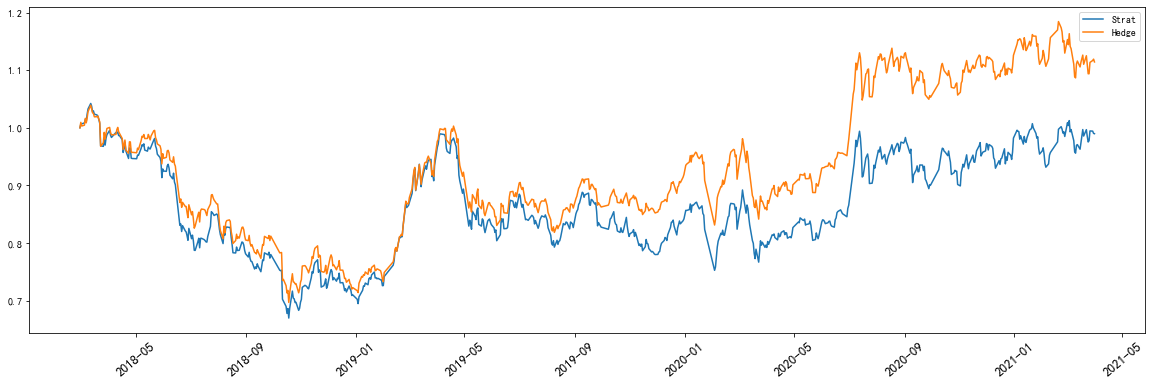

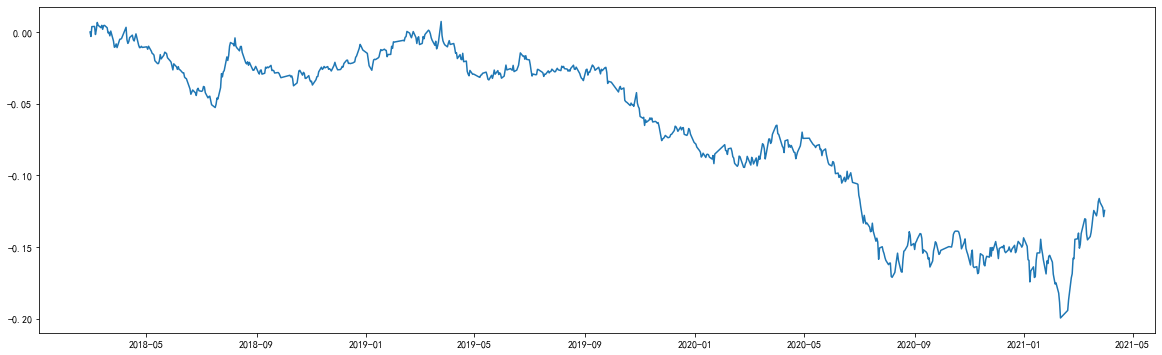

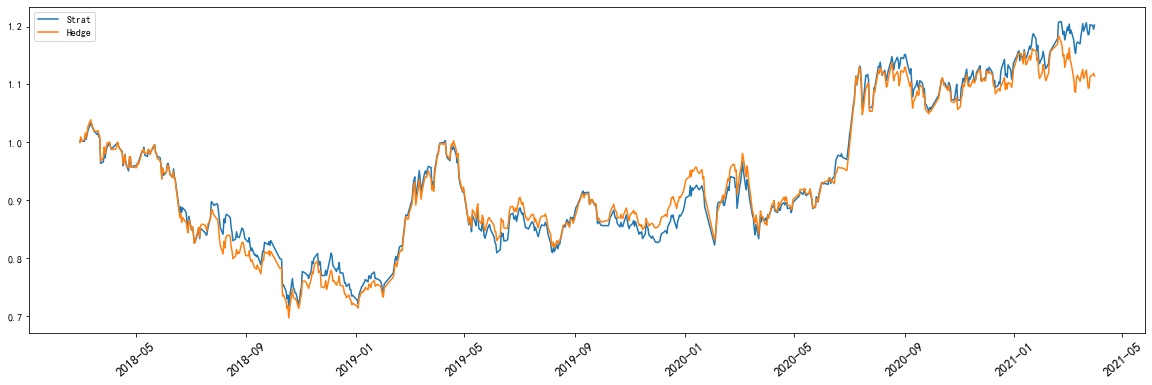

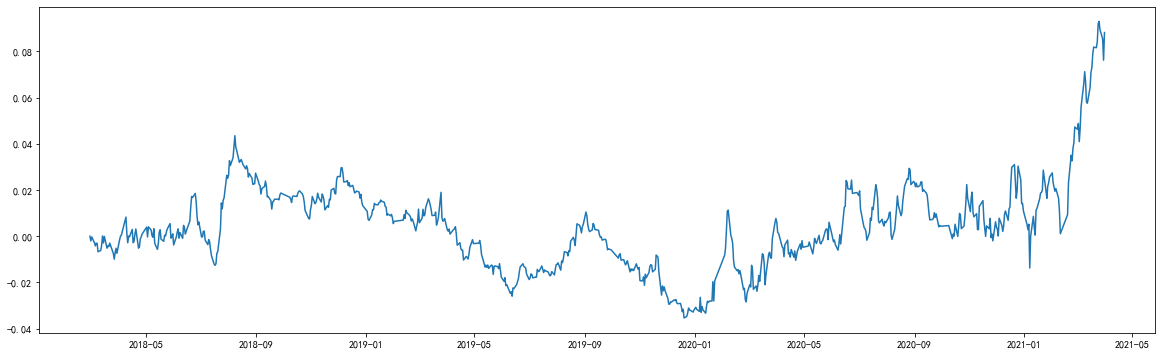

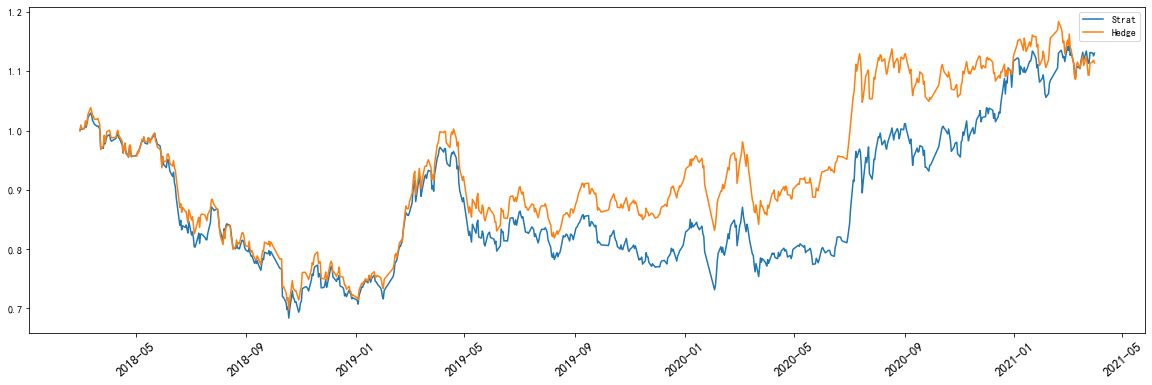

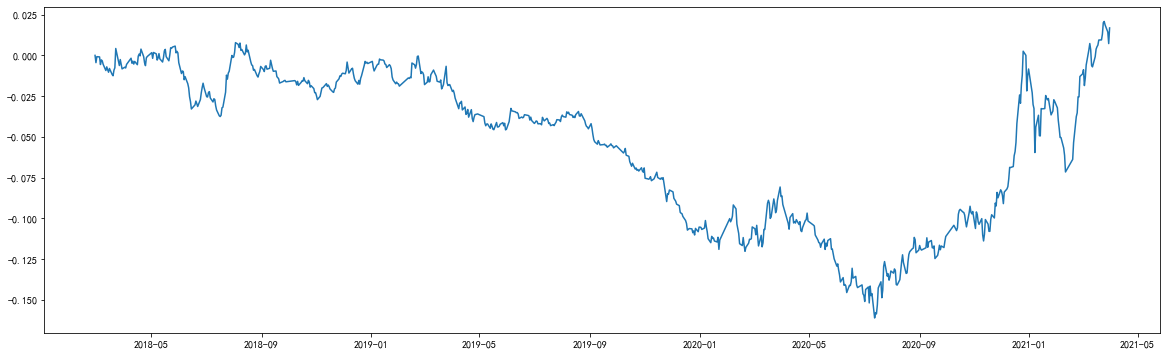

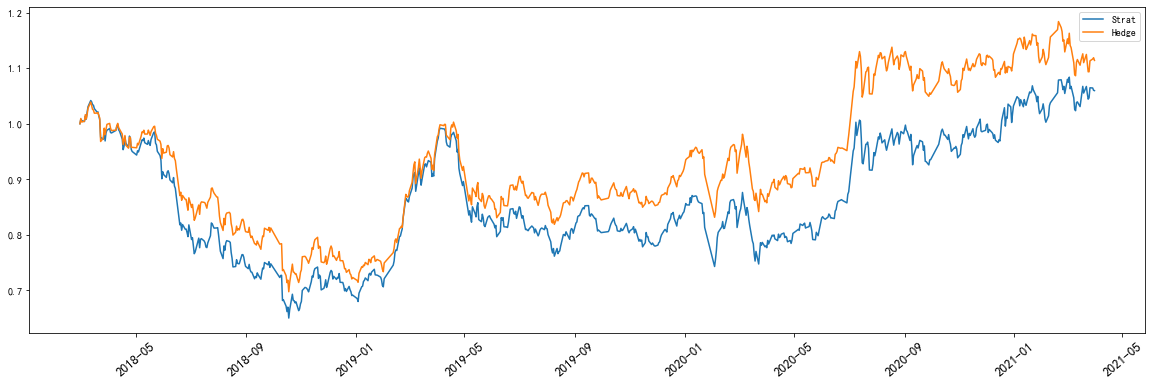

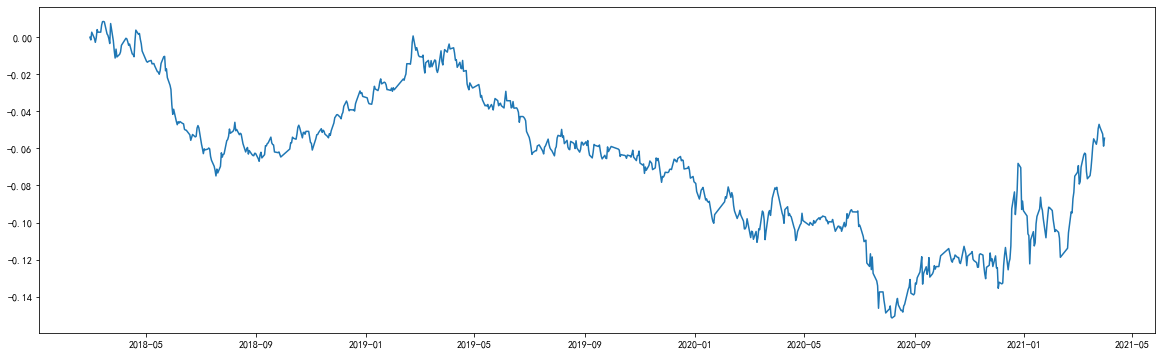

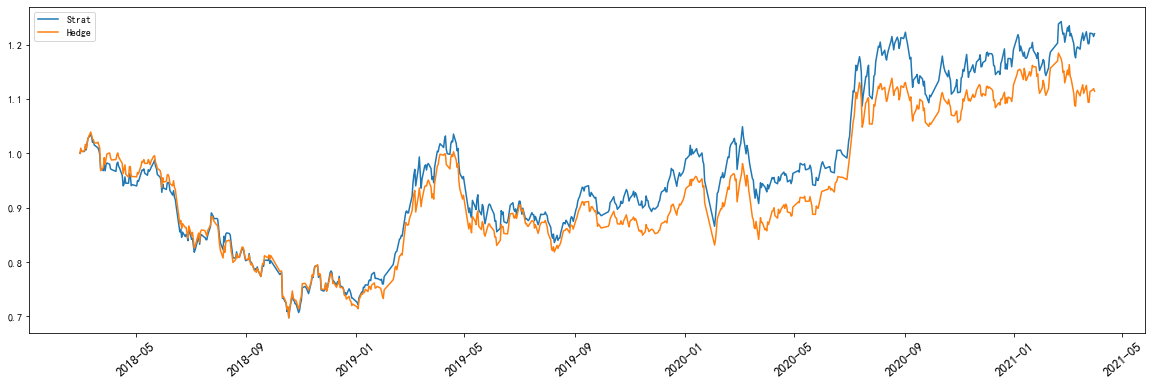

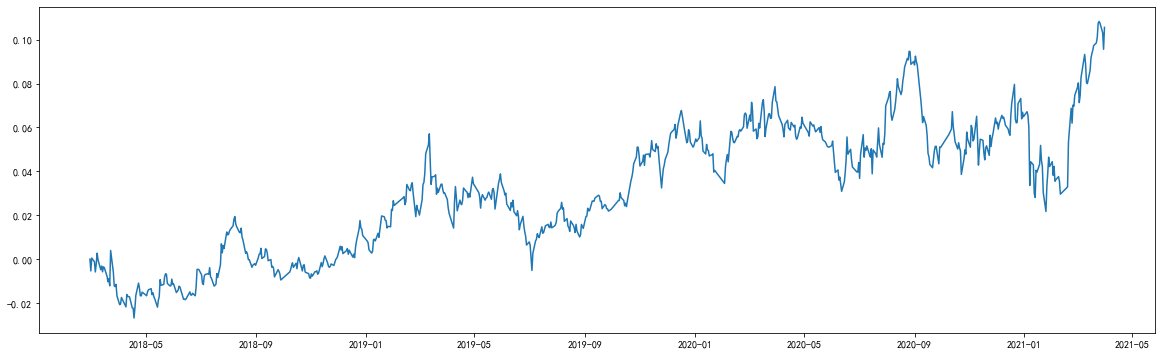

In [24]:
# 将随机搜索里表现最好的三组参数进行回测，并和之前作为对照的回测进行比较
for i in range(len(res_dict)):
    ratio_dict = res_dict[i]

    threshold_df = pd.DataFrame(sector_list['symbol'].to_list()).T
    threshold_df.columns=sector_list['symbol'].to_list()
    threshold_df = threshold_df.apply(threshold_func, args = (ratio_dict,))
    threshold_df = threshold_df.dropna(how='all')

    chosen = pd.DataFrame(threshold_df.index.to_list()).T
    chosen.columns=threshold_df.index.to_list()
    chosen = chosen.apply(choose_sector_func)
    
    threshold_df = pd.DataFrame(sector_list['symbol'].to_list()).T
    threshold_df.columns=sector_list['symbol'].to_list()
    threshold_df = threshold_df.apply(threshold_func, args = (ratio_dict,))
    threshold_df = threshold_df.dropna(how='all')

    chosen = pd.DataFrame(threshold_df.index.to_list()).T
    chosen.columns=threshold_df.index.to_list()
    chosen = chosen.apply(choose_sector_func)
    capacity = 1
    trade_list = pd.DataFrame( index = ['return_chg','close_when_buying','close_when_selling'] )
    date_list = threshold_df.index.to_list()
    date_list = list(set(date_list).intersection(set(month_series_2)))
    date_list.sort()
    performance_list = pd.DataFrame(columns=['date','capacity']).set_index('date')
    for i in range(len(date_list) - 2): 
        trade_list, capacity = trade(trade_list, capacity, date_list[i], date_list[i+1])
    #     performance_list = performance_list.append([{'date':date_list[i+1], 'capacity':capacity}], ignore_index=True)
        display_performance(trade_list, performance_list, capacity, date_list[i+1], date_list[i+2])

    hedge_data = performance_list_hedge
    hedge_data.index = pd.to_datetime(hedge_data.index, format='%Y-%m-%d').date
    performance_list.index = pd.to_datetime(performance_list.index, format='%Y-%m-%d').date
    performance = pd.concat([performance_list, hedge_data], axis=1)
    performance.columns = ['Strat','Hedge']
    performance.plot(figsize=(20,6))
    plt.xticks(size='small',rotation=40,fontsize=13)
    plt.show()
    performance_1 = performance.dropna(axis=0, how='any')
    alpha = (performance_1['Strat'] - performance_1['Hedge'])
    alpha.plot(figsize=(20,6))